# Laboratorio 1 

In [13]:

pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
import statsmodels.api as sm

#Lectura y transformación de datos
pd.set_option('display.float_format', '{:.2f}'.format)

c2024 = pd.read_excel("./Data/Consumos_2024.xlsx", skiprows = 6, nrows = 300) #Solo 300 registros
c2025 = pd.read_excel("./Data/Consumos_2025.xlsx", skiprows = 6, nrows = 5)
consumos = pd.concat([c2024, c2025], ignore_index= True)
i2024 = pd.read_excel("./Data/Importaciones_combustibles_2024.xlsx", skiprows = 6, nrows = 288)
i2025 = pd.read_excel("./Data/Importaciones_combustibles_2025.xlsx", skiprows = 6, nrows = 5)
importaciones = pd.concat([i2024, i2025], ignore_index= True)
consumos.loc[:203, 'Diesel bajo azufre'] = consumos.loc[:203, 'Diesel alto azufre']
consumos['Diesel'] = consumos['Diesel bajo azufre']
consumos['Fecha'] = pd.to_datetime(consumos['Fecha']).dt.strftime('%Y-%m')
importaciones['Fecha'] = pd.to_datetime(consumos['Fecha']).dt.strftime('%Y-%m')

importaciones


def graficar_histogramas_boxplot(dataframe, tipo_gasolina, titulo_hist, titulo_box ):
    sns.histplot(
    data=dataframe,
    x=tipo_gasolina,
    stat="density",
    kde=True,
    bins=30
    )
    plt.title(titulo_hist)
    plt.xlabel("Valor")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

    plt.figure()
    sns.boxplot(x=dataframe[tipo_gasolina])
    plt.title(titulo_box)
    plt.show()


# Análisis exploratorio

Primero haremos un resumen de las variables objetivo

## Consumos

### Resumen inicial de los datos

In [34]:
consumos[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo', 'Diesel']].describe()

,Gasolina regular,Gasolina superior,Gas licuado de petróleo,Diesel
count,305.00,305.00,305.00,305.00
mean,405016.80,474465.50,322885.82,880197.59
std,225100.21,117354.12,118981.77,231982.99
min,160741.90,300242.78,167818.14,507662.65
25%,216560.79,385044.97,227154.97,701255.47
50%,290286.65,424438.71,268875.10,807692.10
75%,570267.25,575720.92,407953.78,1062409.16
max,942394.34,790948.04,600453.87,1474651.06


Del resumen inicial podemos ver estos detalles interesantes:

- El valor máxmo encontrado en los consumos de la gasolina regular puede ser considerado como un dato atípico porque vemos que la mayoría de la información se concentra en un rango de GTQ.210,000.00 y GTQ.570,000.00. Solamente un 25% se encuentra por encima de esos valores y vemos que la media posiblemente este siendo afectada por ese valor pues está bastante alejada de la media. 
- El diesel tiene un precio superior al resto de combustibles o es más consumido que los demás pues sus valores de media son mayores a los de los demás combustibles.  
- La gasolina superior, el gas licuado de petroleo y el diesel no muestran una diferencia tan pronunciada entre la mediana y le media como la gasolina regular, esto podría indicar que tienen una distribución normal. 

### Valores NA

Ahora veremos cuales variables tienen valores NA 

In [36]:
print(f"NA's en la variable de gasolina regular {consumos['Gasolina regular'].isna().sum()} ")
print(f"NA's en la variable de gasolina superior {consumos['Gasolina superior'].isna().sum()} ")
print(f"NA's en la variable del gas licuado de petróleo {consumos['Gas licuado de petróleo'].isna().sum()}")
print(f"NA's en la variable del diesel {consumos['Diesel'].isna().sum()} ")


NA's en la variable de gasolina regular 0 
NA's en la variable de gasolina superior 0 
NA's en la variable del gas licuado de petróleo 0
NA's en la variable del diesel 0 


Vemos que no hay nigún NA en ninguna de las columnas, por lo tanto no haremos operaciones de sustitución de valores y limpieza. 

### Histogramas y distribución

Ahora haremos histogramas y confirmaremos nuestras primeras conjeturas sobre los datos que hicimos en base al resumen anterior. 

Primero vamos con la distribución de la gasolina regular

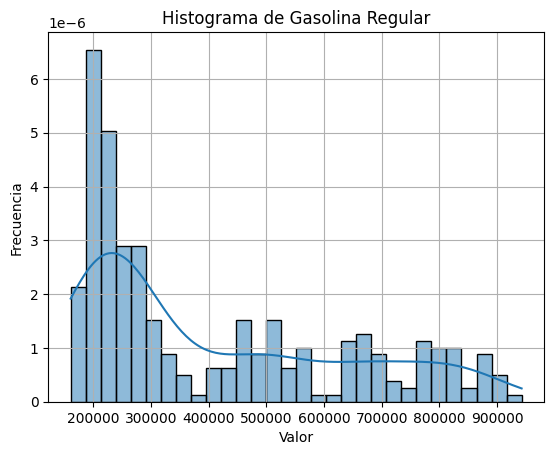

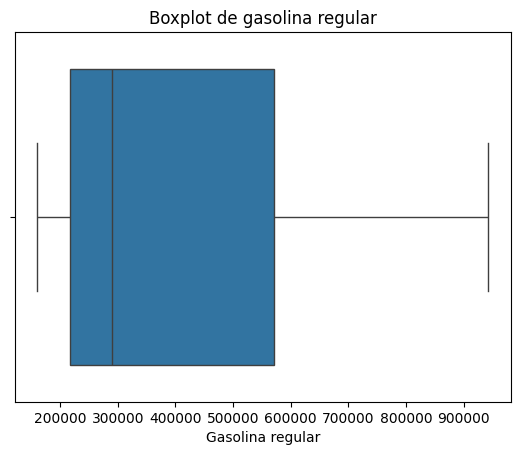

In [29]:

graficar_histogramas_boxplot(consumos, "Gasolina regular", "Histograma de Gasolina Regular", "Boxplot de gasolina regular")


Vemos que los datos tienen una sesgo positivo a la derecha, la mayoría de la información está concentrada entre el valor mínimo y el percentil 75. Por el momento no haremos ninguna tranformación pues los valores atípicos podrían representar algún patrón en la serie de tiempo. 

Ahora veremos la distribución de la gasolina superior

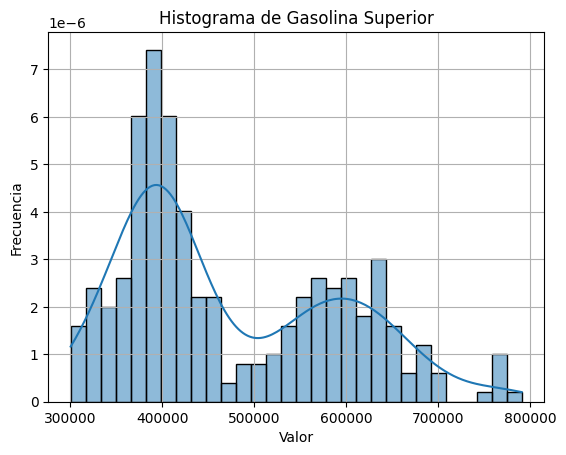

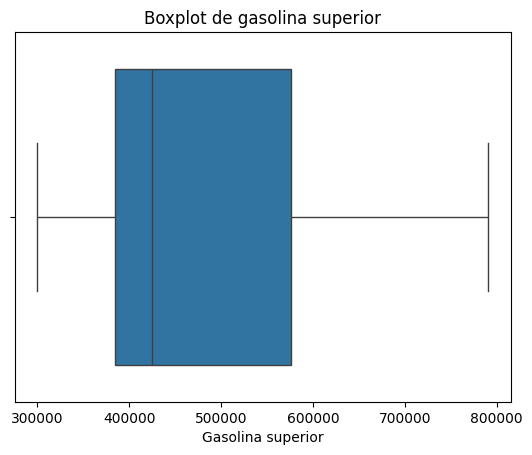

In [30]:

graficar_histogramas_boxplot(consumos, "Gasolina superior", "Histograma de Gasolina Superior", "Boxplot de gasolina superior")

Se puede notar que hay 2 picos enla distribución aunque uno es más pronunciado que otro, podemos dedecuir que la información para este tipo de combustible tiene una distribución bimodal. Esto puede sugerir que en la serie de tiempo podamos llegar a encontrar estacionalidad pues hay ciertos periodos de tiempo en donde las ventas aumentan o que desde hace algunos años haya alguna tendencia a la alta para los consumos d eeste tipo de combustible. 

Ahora veremos para el gas licuado de petróleo

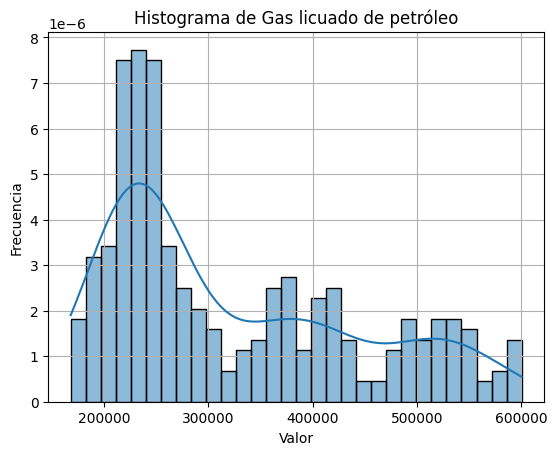

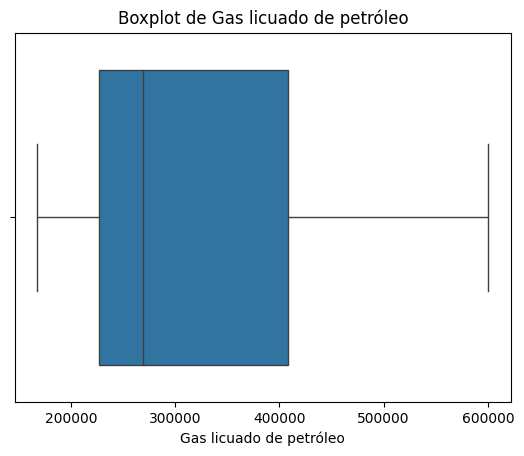

In [31]:

graficar_histogramas_boxplot(consumos, "Gas licuado de petróleo", "Histograma de Gas licuado de petróleo", "Boxplot de Gas licuado de petróleo")

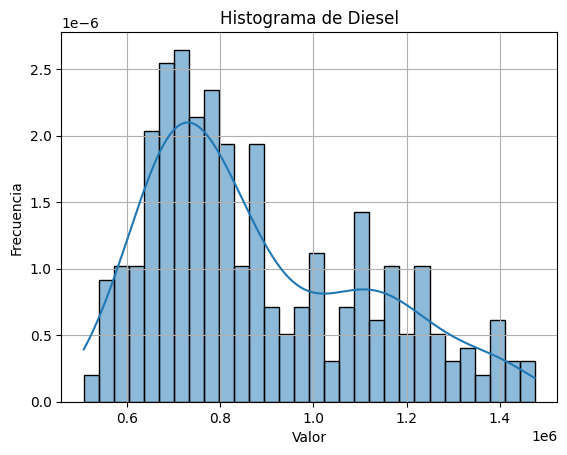

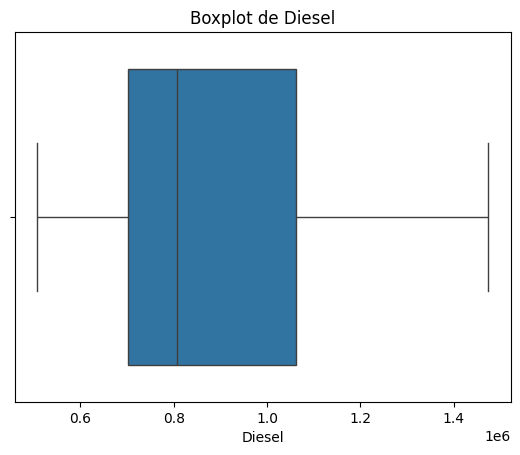

In [37]:
graficar_histogramas_boxplot(consumos, "Diesel", "Histograma de Diesel", "Boxplot de Diesel")

### Evolución temporal

Ahora veremos la evolución de los consumos de los diferentes tipos de combustibles a lo largo del tiempo. 

Primero vamos con la gasolina regular

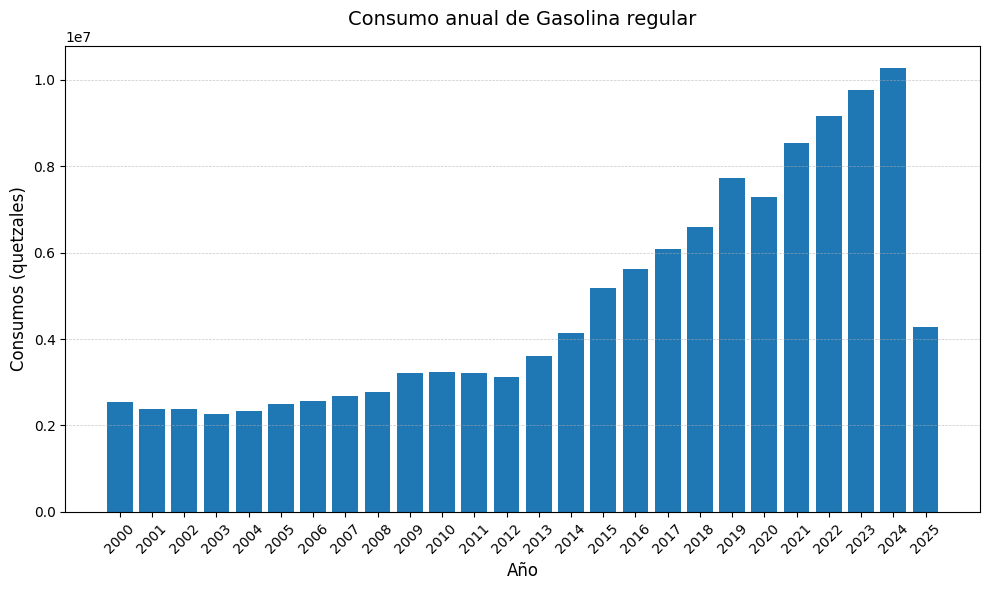

In [40]:
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], format='%Y-%m')
consumos['año'] = consumos['Fecha'].dt.year
consumos_grouped = consumos.groupby('año')


suma_regular = consumos_grouped['Gasolina regular'].sum()


def graficar_barras(dataset, xTitle, yTitle, generalTitle):
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(dataset.index, dataset.values, width=0.8)
    ax.set_xlabel(xTitle, fontsize=12)
    ax.set_ylabel(yTitle, fontsize=12)
    ax.set_title(generalTitle, fontsize=14, pad=15)
    ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.xticks(dataset.index, rotation=45)
    plt.tight_layout()
    plt.show()
    
graficar_barras(suma_regular, 'Año', 'Consumos (quetzales)', 'Consumo anual de Gasolina regular')

Ahora vamos con la gasolina superior

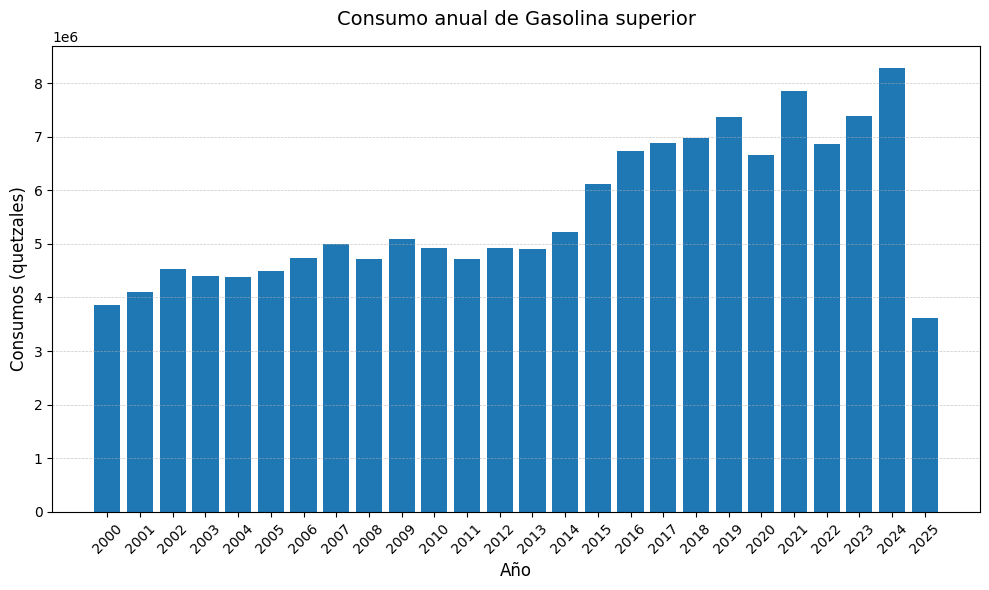

In [19]:
suma_superior = consumos_grouped['Gasolina superior'].sum()

graficar_barras(suma_superior, 'Año', 'Consumos (quetzales)', 'Consumo anual de Gasolina superior')

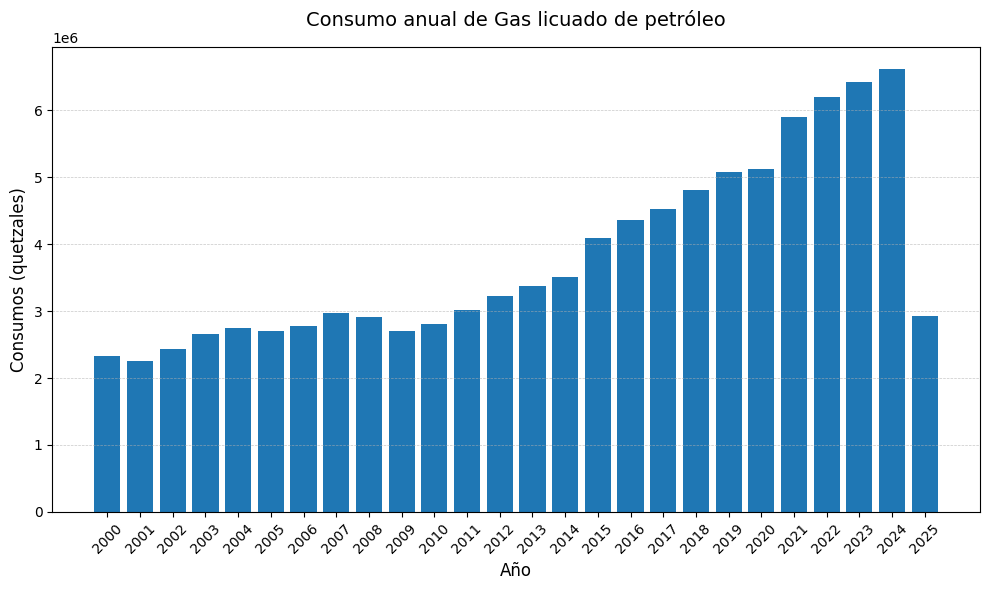

In [18]:
suma_gas_licuado = consumos_grouped['Gas licuado de petróleo'].sum()

graficar_barras(suma_gas_licuado, 'Año', 'Consumos (quetzales)', 'Consumo anual de Gas licuado de petróleo')

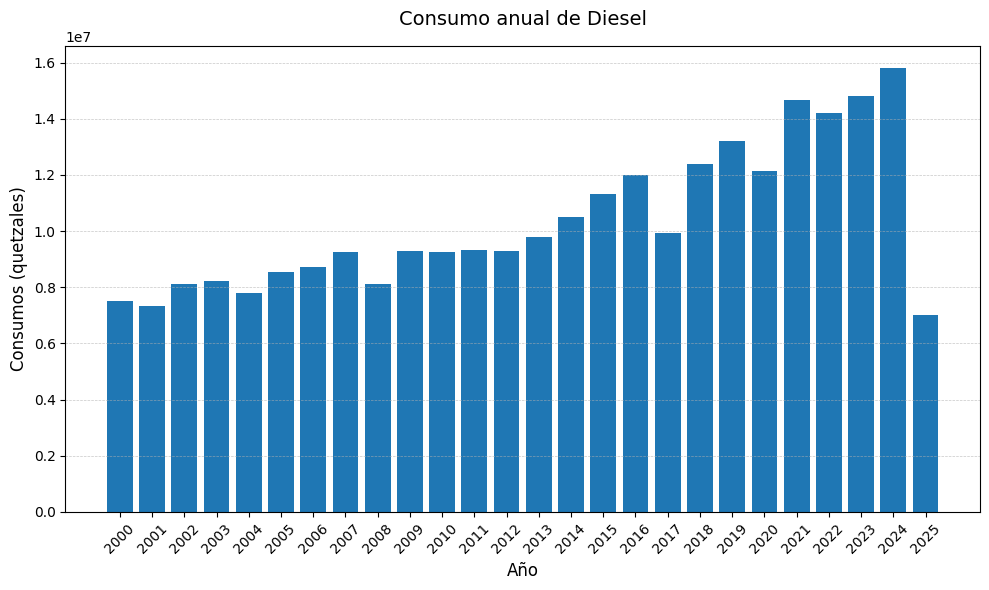

In [41]:
suma_diesel = consumos_grouped['Diesel'].sum()

graficar_barras(suma_diesel, 'Año', 'Consumos (quetzales)', 'Consumo anual de Diesel')


### Evolución por mes

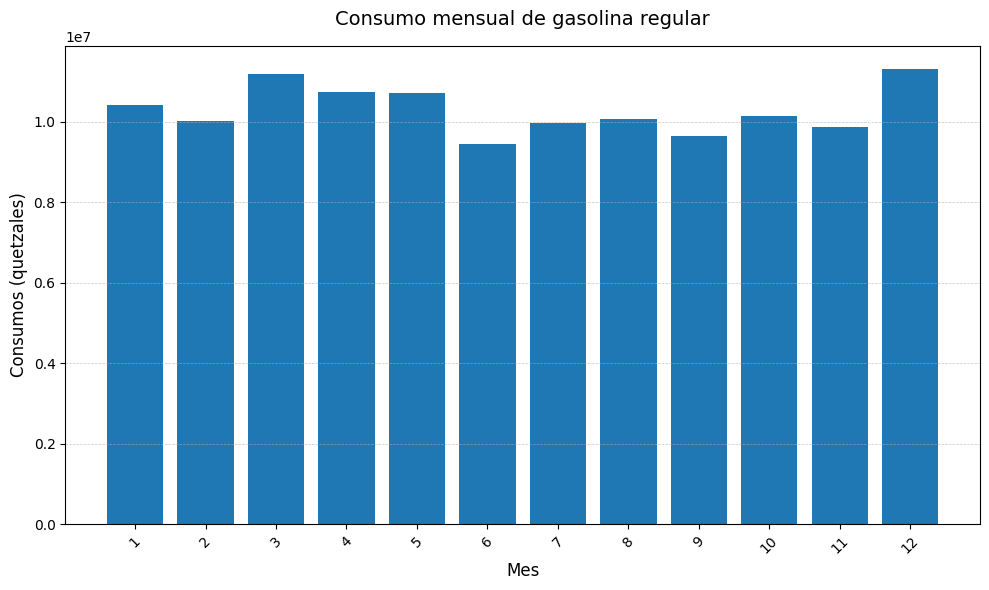

In [42]:
consumos['mes'] = consumos['Fecha'].dt.month
consumos_grouped_monthly = consumos.groupby('mes')


suma_regular_mensual = consumos_grouped_monthly['Gasolina regular'].sum()

graficar_barras(suma_regular_mensual, 'Mes', 'Consumos (quetzales)', 'Consumo mensual de gasolina regular')

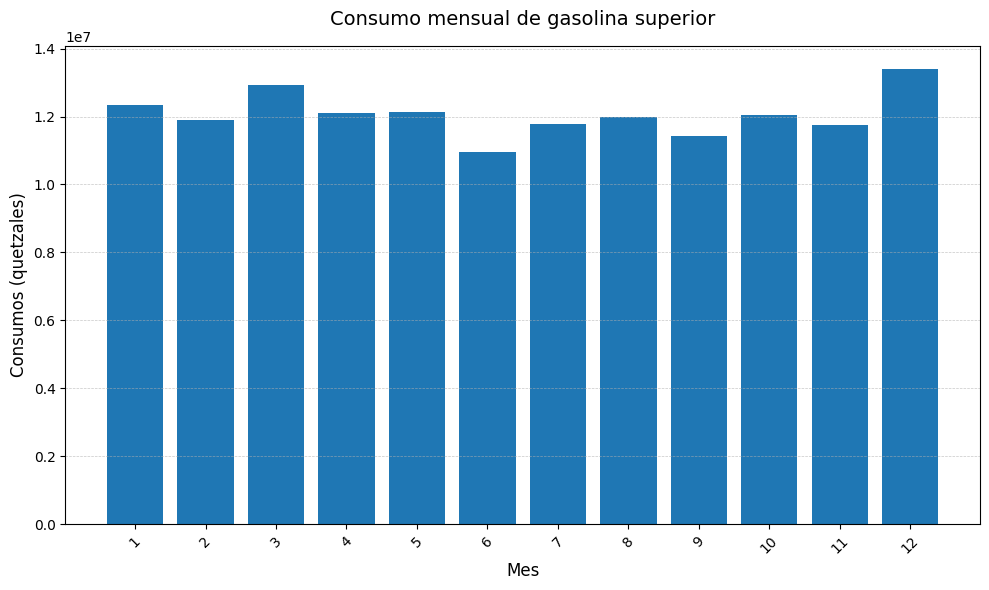

In [22]:
suma_superior_mensual = consumos_grouped_monthly['Gasolina superior'].sum()

graficar_barras(suma_superior_mensual, 'Mes', 'Consumos (quetzales)', 'Consumo mensual de gasolina superior')

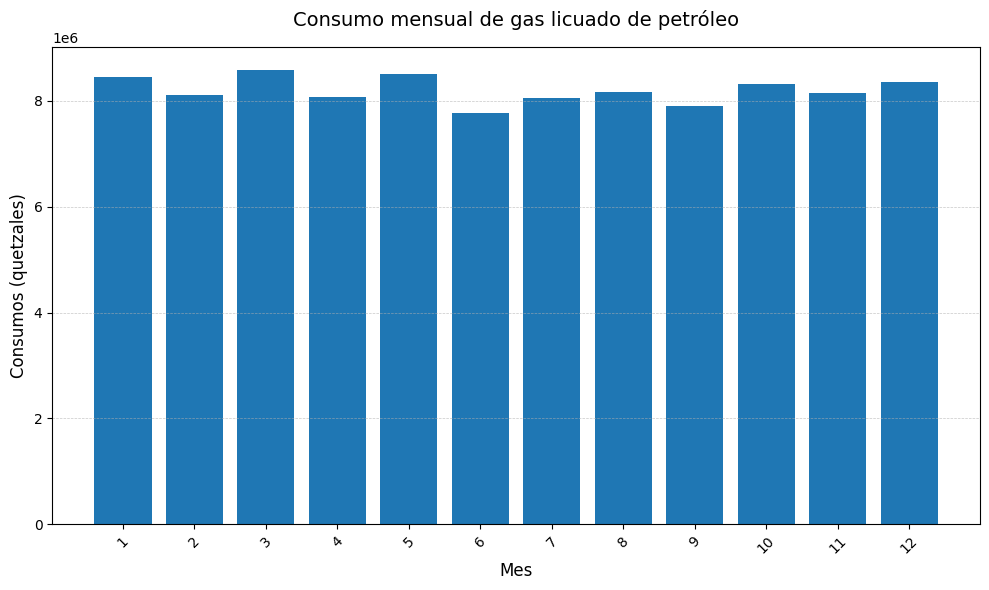

In [23]:
suma_gas_mensual = consumos_grouped_monthly['Gas licuado de petróleo'].sum()

graficar_barras(suma_gas_mensual, 'Mes', 'Consumos (quetzales)', 'Consumo mensual de gas licuado de petróleo')

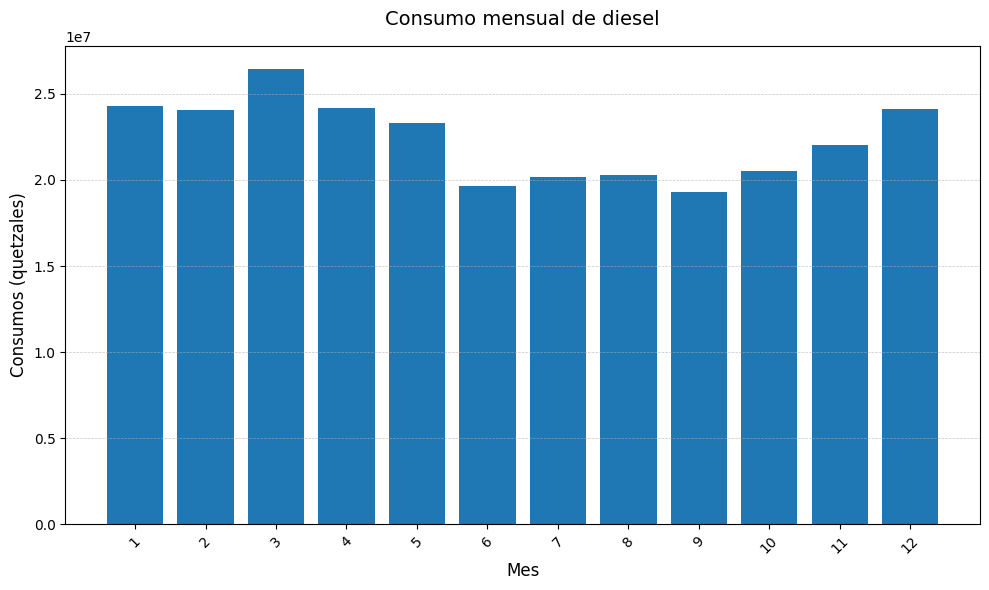

In [43]:
suma_diesel_mensual = consumos_grouped_monthly['Diesel bajo azufre'].sum()

graficar_barras(suma_diesel_mensual, 'Mes', 'Consumos (quetzales)', 'Consumo mensual de diesel')

## Importaciones

## Analisis Series de Tiempo


## IMPORTACIONES

Primero obtenemos los datos filtrados

In [21]:
# Asegurar que los nombres de columnas estén limpios
importaciones.columns = importaciones.columns.str.strip()

# Seleccionar columnas específicas
columnas_deseadas = [
    'Fecha',
    'Gasolina superior',
    'Gasolina regular',
    'Gas licuado de petróleo',
    'Diesel bajo azufre'
]

# Filtrar el DataFrame
importaciones_filtrado = importaciones[columnas_deseadas]
consumo_filtrado = consumos[columnas_deseadas]


Ahora graficamos

C:\Users\ppguz\AppData\Local\Temp\ipykernel_23648\4189139993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  importaciones_filtrado['Fecha'] = pd.to_datetime(importaciones_filtrado['Fecha'])


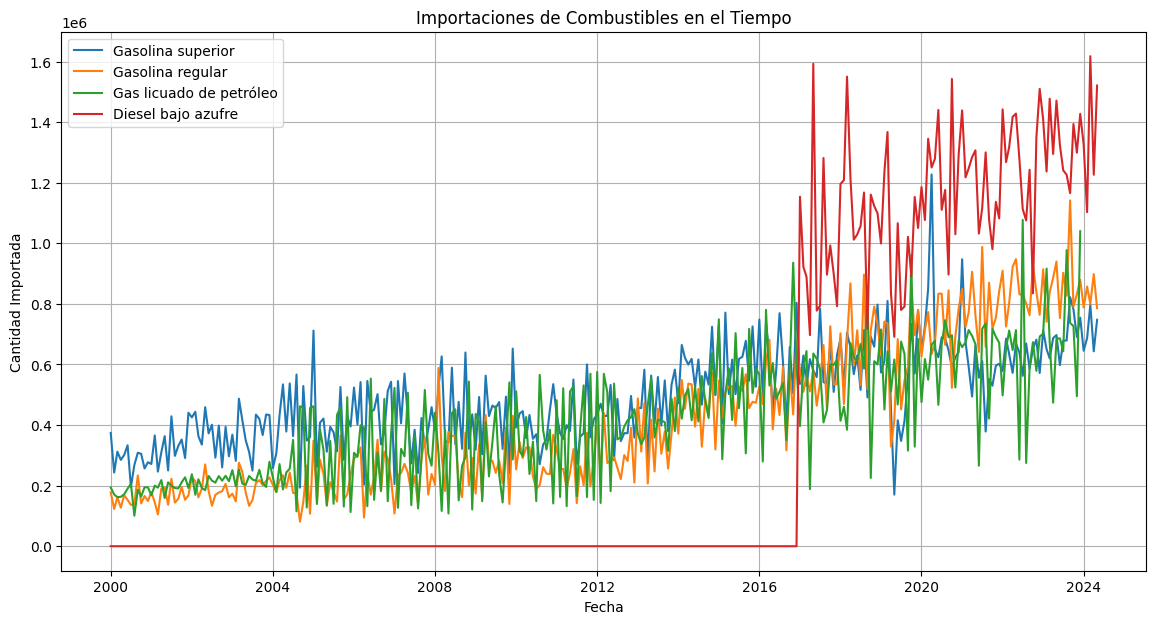

In [22]:
import matplotlib.pyplot as plt

# Asegurarse que la columna Fecha sea de tipo datetime
importaciones_filtrado['Fecha'] = pd.to_datetime(importaciones_filtrado['Fecha'])

plt.figure(figsize=(14, 7))

for columna in columnas_deseadas[1:]:  # Excluimos 'Fecha'
    plt.plot(importaciones_filtrado['Fecha'], importaciones_filtrado[columna], label=columna)

plt.title('Importaciones de Combustibles en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Importada')
plt.legend()
plt.grid(True)
plt.show()


Obtenemos sus componentes

<Figure size 1400x1000 with 0 Axes>

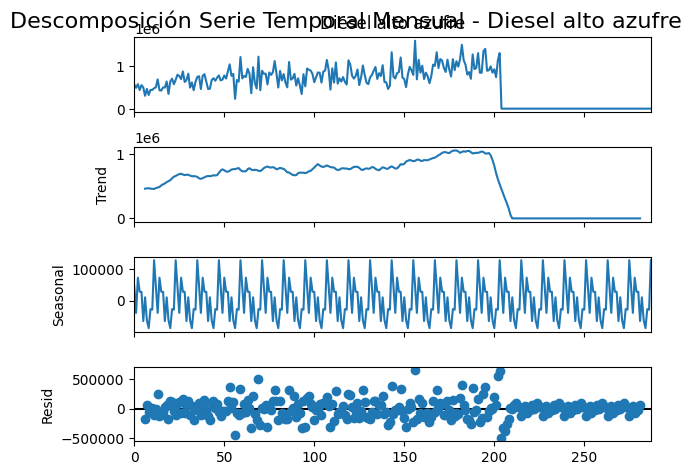

<Figure size 1400x1000 with 0 Axes>

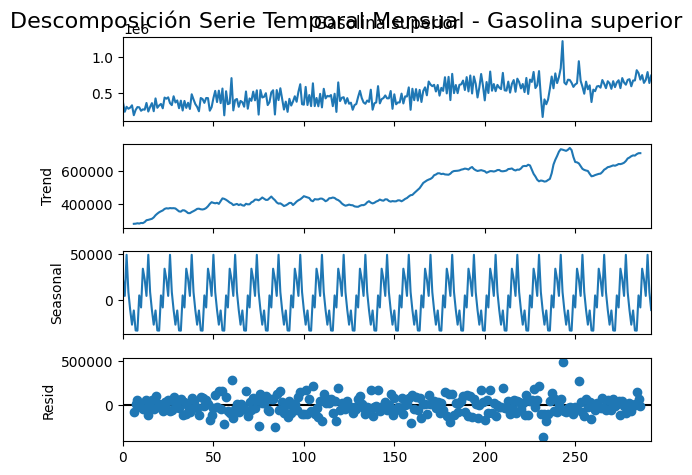

<Figure size 1400x1000 with 0 Axes>

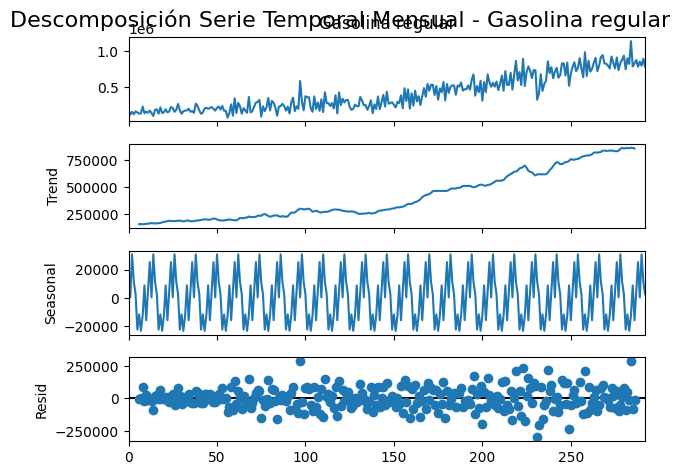

<Figure size 1400x1000 with 0 Axes>

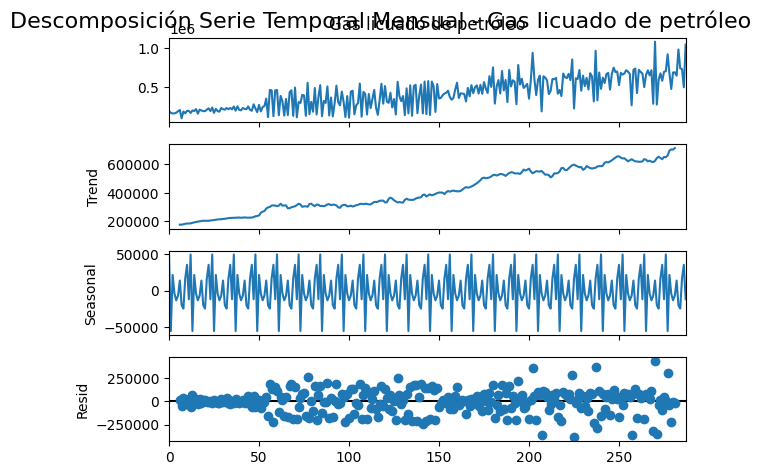

In [10]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Lista de columnas a analizar (excluyendo 'Fecha' porque ya es índice)
columnas_a_analizar = [
    'Diesel alto azufre',
    'Gasolina superior',
    'Gasolina regular',
    'Gas licuado de petróleo'
]

for columna in columnas_a_analizar:
    serie = importaciones_filtrado[columna].dropna()

    # Descomposición aditiva con periodo 12 (mensual)
    resultado = seasonal_decompose(serie, model='additive', period=12)

    # Graficar
    plt.figure(figsize=(14, 10))
    resultado.plot()
    plt.suptitle(f'Descomposición Serie Temporal Mensual - {columna}', fontsize=16)
    plt.show()


### Analisis

Podemos ver que todas representan tendencia a excepcion del diesel que su tendenca es negativa. Tambien podemos ver que en todas hay estacionalidad lo que significa que los precios de cada combustible se han ido aumentando debido a la altademanda y tambien que hay epocas en donde cada uno es mas exigido que otro , pero se puede observar que el disel ha estado en desuso ultimadamente.

## Consumo

Grafica

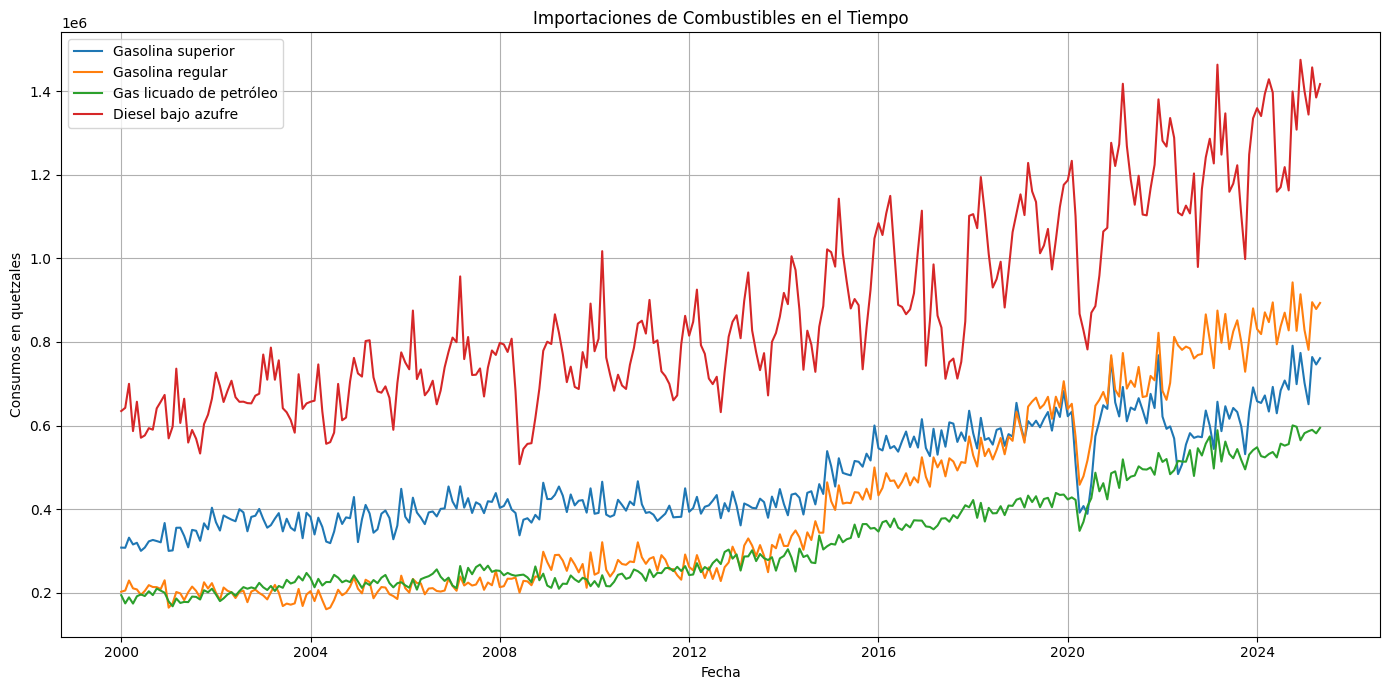

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurar formato datetime para graficar correctamente
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], format='%Y-%m')

plt.figure(figsize=(14, 7))
for columna in columnas_deseadas[1:]:  # Excluimos 'Fecha'
    plt.plot(consumos['Fecha'], consumos[columna], label=columna)

plt.title('Importaciones de Combustibles en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Consumos en quetzales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Componentes

<Figure size 1400x1000 with 0 Axes>

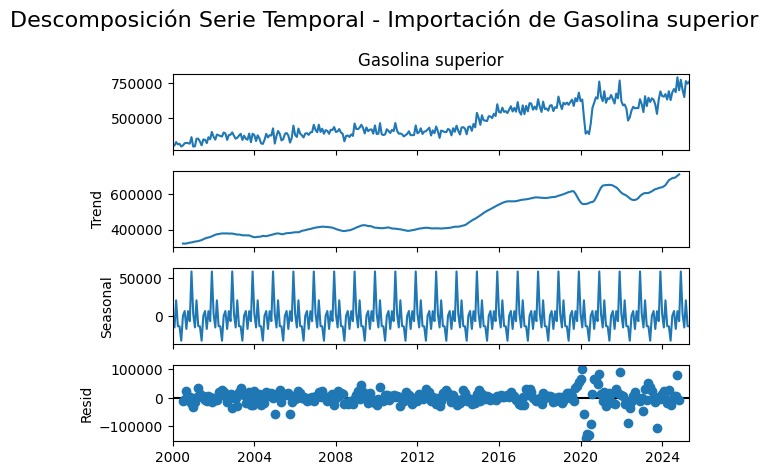

<Figure size 1400x1000 with 0 Axes>

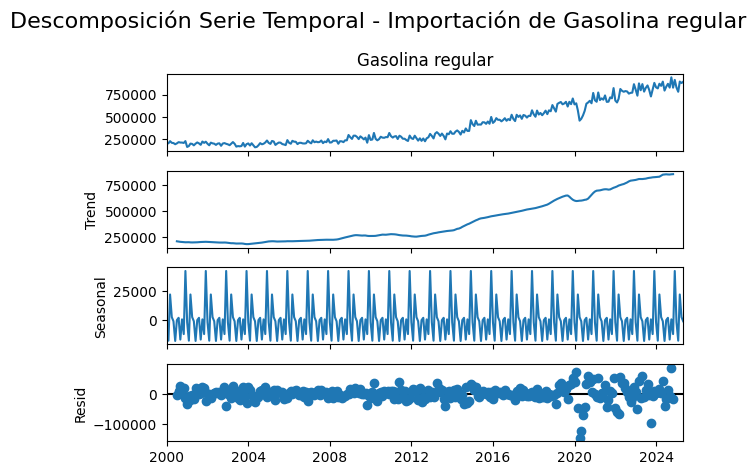

<Figure size 1400x1000 with 0 Axes>

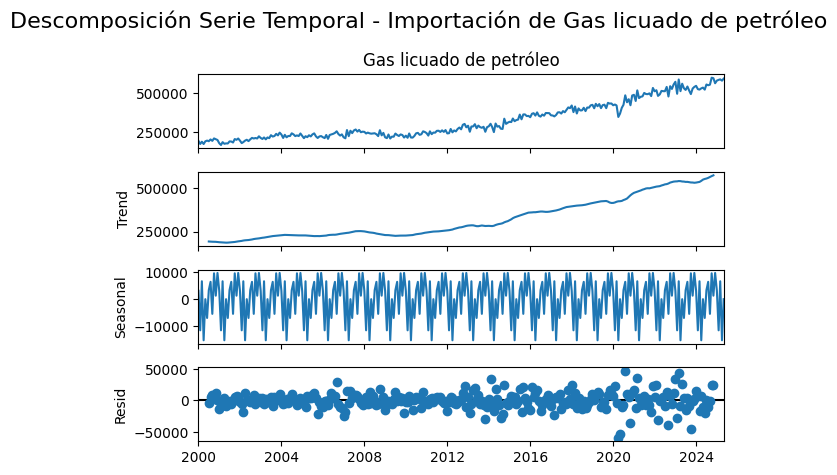

<Figure size 1400x1000 with 0 Axes>

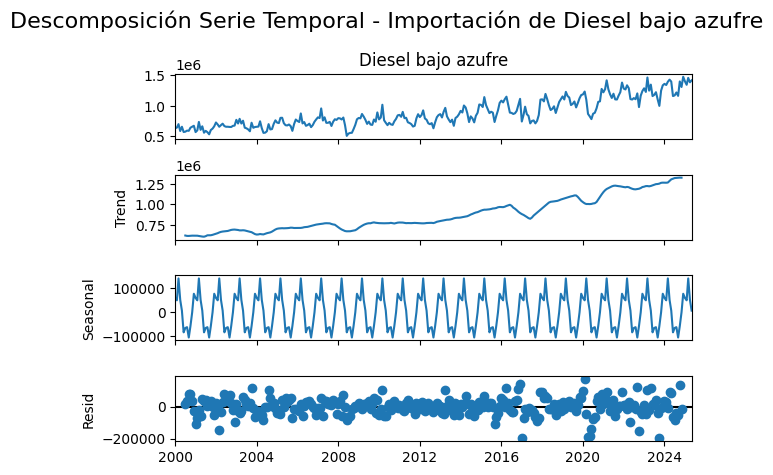

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Establecer Fecha como índice temporal
consumos.set_index('Fecha', inplace=True)

# Convertir a numérico cada columna por si acaso
for col in columnas_deseadas[1:]:
    consumos[col] = pd.to_numeric(consumos[col], errors='coerce')

# Descomposición y gráfica para cada combustible
for columna in columnas_deseadas[1:]:
    serie = consumos[columna].dropna()

    if len(serie) >= 24:  # Al menos 2 años de datos para seasonal_decompose con period=12
        resultado = seasonal_decompose(serie, model='additive', period=12)

        plt.figure(figsize=(14, 10))
        resultado.plot()
        plt.suptitle(f'Descomposición Serie Temporal - Importación de {columna}', fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"[❗] No hay suficientes datos para descomponer la serie: {columna}")


## Analisis

Hemos observado un aumento general en el consumo de todos los combustibles a lo largo del período analizado, lo cual refleja una tendencia creciente sostenida en la demanda energética del país. Esta tendencia puede estar relacionada con una mayor actividad económica, crecimiento del parque vehicular o estacionalidades propias del mercado.

No obstante, se destaca el caso del diésel alto en azufre, cuyo consumo ha mostrado una disminución significativa desde el año 2020. Esta caída podría estar vinculada a diversos factores:

Preferencia del consumidor por combustibles más económicos o eficientes.

Normativas ambientales que desincentivan el uso de diésel con alto contenido de azufre.

Modernización de flotas de transporte, migrando hacia tecnologías más limpias.

Ademas en dodas se puede ver sierta estacionalidad , lo que indica tendencias siempre en el mercado de estar consumiendo el producto